# Noise2Void - 3D Example

In [1]:
# We import all our dependencies.
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os
import zipfile
from tifffile import imread

Using TensorFlow backend.


# Download Example Data
Thanks to Romina Piscitello (Eaton Lab, MPI-CBG) for letting us use her data.

In [2]:
# create a folder for our data
if not os.path.isdir('./data'):
    os.mkdir('./data')

# check if data has been downloaded already
zipPath='data/flywing-data.zip'
if not os.path.exists(zipPath):
    #download and unzip data
    data = urllib.request.urlretrieve('https://cloud.mpi-cbg.de/index.php/s/RKStdwKo4FlFrxE/download', zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall('data')

# Training Data Preparation
For training we will load __one__ low-SNR 3D-tif-volume and use the <code>N2V_DataGenerator</code> to extract non-overlapping 3D-patches. Since N2V is a self-supervised method, we don't need targets.

In [2]:
# We create our DataGenerator-object.
# It will help us load data and extract patches for training and validation.
datagen = N2V_DataGenerator()

In [4]:
imi = imread('/data/Kelin/small_sample.tif')

FileNotFoundError: [Errno 2] No such file or directory: '/data/Kelin/small_sample.tif'

In [30]:
# We will load all the '.tif' files from the 'data' directory. In our case it is only one.
# The function will return a list of images (numpy arrays).
# In the 'dims' parameter we specify the order of dimensions in the image files we are reading.
imgs = datagen.load_imgs_from_directory(directory = "data/Kelin/", dims='ZXY')

# Let's look at the shape of the image
print(imgs[0].shape)
# The function automatically added two extra dimension to the images:
# One at the front is used to hold a potential stack of images such as a movie.
# One at the end could hold color channels such as RGB.

(1, 40, 7104, 10560, 1)


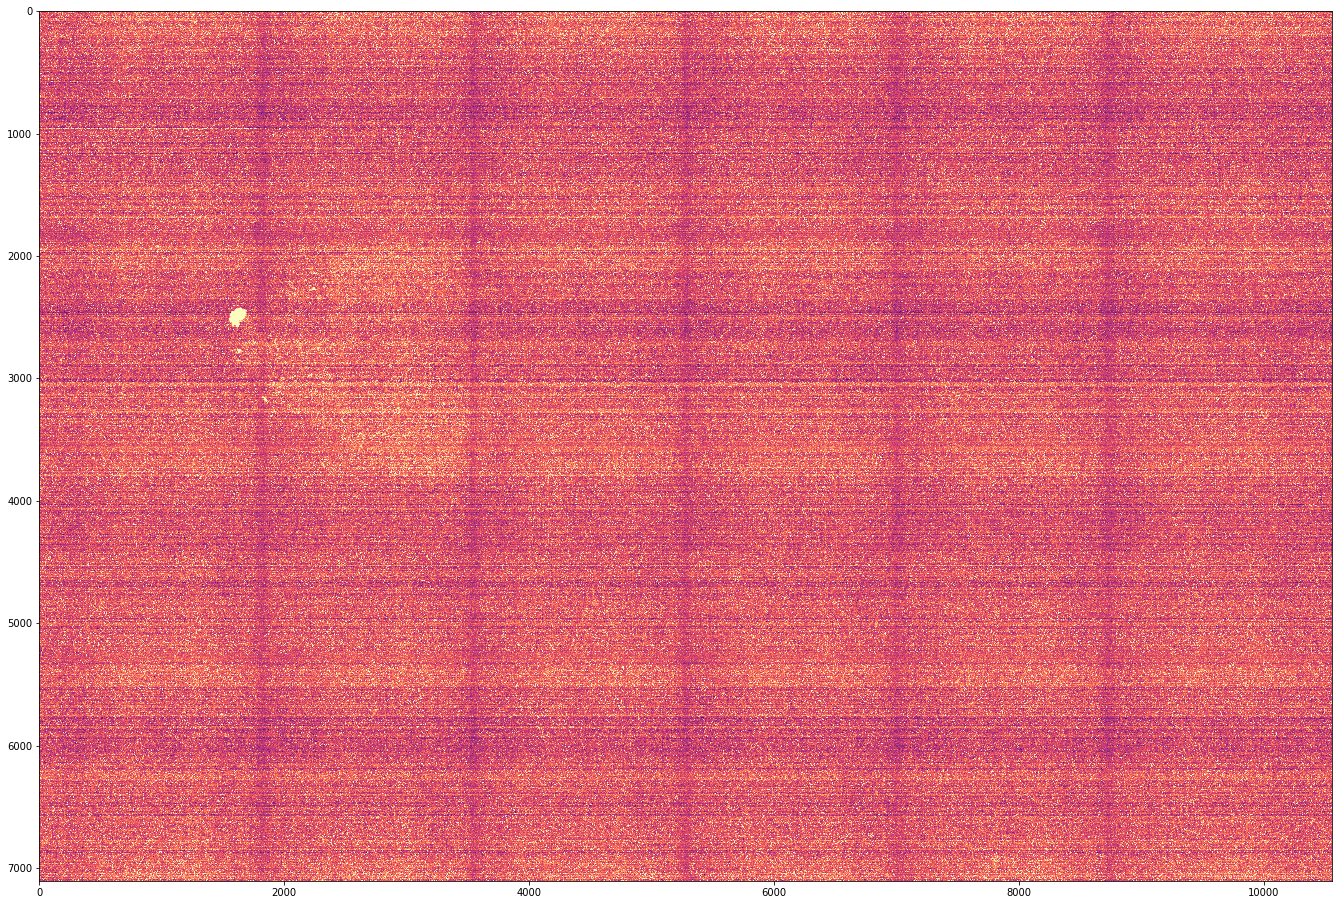

In [8]:
# Let's look at a maximum projection of the volume.
# We have to remove the added extra dimensions to display it.
plt.figure(figsize=(32,16))
plt.imshow(np.max(imgs[0][0,...,0],axis=2), 
           cmap='magma',
           vmin=np.percentile(imgs[0],0.1),
           vmax=np.percentile(imgs[0],99.9)
          )
plt.show()

In [39]:
# Here we extract patches for training and validation.
patches = datagen.generate_patches_from_list(imgs[0], shape=(64,64))

Generated patches: (144320, 64, 64, 1)
Generated patches: (144320, 64, 64, 1)
Generated patches: (144320, 64, 64, 1)
Generated patches: (144320, 64, 64, 1)
Generated patches: (144320, 64, 64, 1)
Generated patches: (144320, 64, 64, 1)
Generated patches: (144320, 64, 64, 1)
Generated patches: (144320, 64, 64, 1)
Generated patches: (144320, 64, 64, 1)
Generated patches: (144320, 64, 64, 1)
Generated patches: (144320, 64, 64, 1)
Generated patches: (144320, 64, 64, 1)
Generated patches: (144320, 64, 64, 1)
Generated patches: (144320, 64, 64, 1)
Generated patches: (144320, 64, 64, 1)
Generated patches: (144320, 64, 64, 1)
Generated patches: (144320, 64, 64, 1)
Generated patches: (144320, 64, 64, 1)
Generated patches: (144320, 64, 64, 1)
Generated patches: (144320, 64, 64, 1)
Generated patches: (144320, 64, 64, 1)
Generated patches: (144320, 64, 64, 1)
Generated patches: (144320, 64, 64, 1)
Generated patches: (144320, 64, 64, 1)
Generated patches: (144320, 64, 64, 1)
Generated patches: (14432

In [41]:
patches.shape

(5772800, 64, 64, 1)

In [60]:
# Patches are created so they do not overlap.
# (Note: this is not the case if you specify a number of patches. See the docstring for details!)
# Non-overlapping patches enable us to split them into a training and validation set.
X = patches[:10000]
X_val = patches[10000:120000]

In [11]:
# Just in case you don't know how to access the docstring of a method:
datagen.generate_patches_from_list?

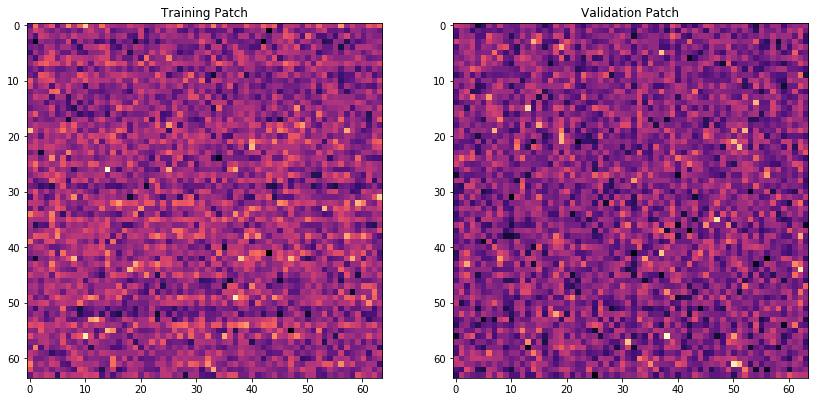

In [45]:
# Let's look at two patches.
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[100,...,0],cmap='magma')
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(X_val[0,...,0],cmap='magma')
plt.title('Validation Patch');

## Configure
Noise2Void comes with a special config-object, where we store network-architecture and training specific parameters. See the docstring of the <code>N2VConfig</code> constructor for a description of all parameters.

When creating the config-object, we provide the training data <code>X</code>. From <code>X</code> we extract <code>mean</code> and <code>std</code> that will be used to normalize all data before it is processed by the network. We also extract the dimensionality and number of channels from <code>X</code>.

Compared to supervised training (i.e. traditional CARE), we recommend to use N2V with an increased <code>train_batch_size</code> and <code>batch_norm</code>.
To keep the network from learning the identity we have to manipulate the input pixels during training. For this we have the parameter <code>n2v_manipulator</code> with default value <code>'uniform_withCP'</code>. Most pixel manipulators will compute the replacement value based on a neighborhood. With <code>n2v_neighborhood_radius</code> we can control its size. 

Other pixel manipulators:
* normal_withoutCP: samples the neighborhood according to a normal gaussian distribution, but without the center pixel
* normal_additive: adds a random number to the original pixel value. The random number is sampled from a gaussian distribution with zero-mean and sigma = <code>n2v_neighborhood_radius</code>
* normal_fitted: uses a random value from a gaussian normal distribution with mean equal to the mean of the neighborhood and standard deviation equal to the standard deviation of the neighborhood.
* identity: performs no pixel manipulation

For faster training multiple pixels per input patch can be manipulated. In our experiments we manipulated about 0.198% of the input pixels per patch. For a patch size of 64 by 64 pixels this corresponds to about 8 pixels. This fraction can be tuned via <code>n2v_perc_pix</code>.

For Noise2Void training it is possible to pass arbitrarily large patches to the training method. From these patches random subpatches of size <code>n2v_patch_shape</code> are extracted during training. Default patch shape is set to (64, 64), but since this is an 3D example we obviously need to specify a triple, here (32, 64, 64).  

<font color='red'>Warning:</font> to make this example notebook execute faster, we have set <code>train_epochs</code> to only 20. <br>For better results we suggest 100 to 200 <code>train_epochs</code>.

In [61]:
# You can increase "train_steps_per_epoch" to get even better results at the price of longer computation. 
config = N2VConfig(X, unet_kern_size=3, 
                   train_steps_per_epoch=200,train_epochs=400, train_loss='mse', batch_norm=True, 
                   train_batch_size=4, n2v_perc_pix=0.198, n2v_patch_shape=(64, 64), 
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5)

# Let's look at the parameters stored in the config-object.
vars(config)

{'means': ['213.51993'],
 'stds': ['8.384126'],
 'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'unet_residual': False,
 'unet_n_depth': 2,
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'mse',
 'train_epochs': 400,
 'train_steps_per_epoch': 200,
 'train_learning_rate': 0.0004,
 'train_batch_size': 4,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 0.198,
 'n2v_patch_shape': (64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'probabilistic': False}

In [62]:
# a name used to identify the model
model_name = 'n2v_3D_kelin_very_long'
# the base directory in which our model will live
basedir = 'models'
# We are now creating our network model.
model = N2V(config=config, name=model_name, basedir=basedir)

/home/ninatubau/n2v/n2v/models/n2v_standard.py:409: UserWarning: output path for model already exists, files may be overwritten: /home/ninatubau/n2v/examples/3D/models/n2v_3D_kelin_very_long
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


## Training

In [63]:
history = model.train(X, X_val)

8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 110000/110000 [00:23<00:00, 4608.41it/s]


Epoch 1/400
200/200 [==============================] - 292s 1s/step - loss: 1.3183 - n2v_mse: 1.3183 - n2v_abs: 0.8984 - val_loss: 2.9379 - val_n2v_mse: 2.9379 - val_n2v_abs: 1.2649
Epoch 2/400
200/200 [==============================] - 291s 1s/step - loss: 1.0055 - n2v_mse: 1.0055 - n2v_abs: 0.7873 - val_loss: 1.2848 - val_n2v_mse: 1.2848 - val_n2v_abs: 0.8796
Epoch 3/400
200/200 [==============================] - 292s 1s/step - loss: 0.9845 - n2v_mse: 0.9845 - n2v_abs: 0.7738 - val_loss: 0.9547 - val_n2v_mse: 0.9547 - val_n2v_abs: 0.7601
Epoch 4/400
200/200 [==============================] - 292s 1s/step - loss: 0.9096 - n2v_mse: 0.9096 - n2v_abs: 0.7445 - val_loss: 0.9295 - val_n2v_mse: 0.9295 - val_n2v_abs: 0.7488
Epoch 5/400
200/200 [==============================] - 291s 1s/step - loss: 0.9674 - n2v_mse: 0.9674 - n2v_abs: 0.7623 - val_loss: 0.9718 - val_n2v_mse: 0.9718 - val_n2v_abs: 0.7649
Epoch 6/400
200/200 [==============================] - 292s 1s/step - loss: 0.9513 - n2v_m

Epoch 45/400
200/200 [==============================] - 291s 1s/step - loss: 0.8715 - n2v_mse: 0.8715 - n2v_abs: 0.7304 - val_loss: 0.8813 - val_n2v_mse: 0.8813 - val_n2v_abs: 0.7280
Epoch 46/400
200/200 [==============================] - 289s 1s/step - loss: 0.8680 - n2v_mse: 0.8680 - n2v_abs: 0.7279 - val_loss: 0.8789 - val_n2v_mse: 0.8789 - val_n2v_abs: 0.7284
Epoch 47/400
200/200 [==============================] - 289s 1s/step - loss: 0.8749 - n2v_mse: 0.8749 - n2v_abs: 0.7292 - val_loss: 0.8770 - val_n2v_mse: 0.8770 - val_n2v_abs: 0.7272
Epoch 48/400
200/200 [==============================] - 289s 1s/step - loss: 0.9110 - n2v_mse: 0.9110 - n2v_abs: 0.7353 - val_loss: 0.8789 - val_n2v_mse: 0.8789 - val_n2v_abs: 0.7274
Epoch 49/400
200/200 [==============================] - 290s 1s/step - loss: 0.8838 - n2v_mse: 0.8838 - n2v_abs: 0.7389 - val_loss: 0.8948 - val_n2v_mse: 0.8948 - val_n2v_abs: 0.7333
Epoch 50/400
200/200 [==============================] - 293s 1s/step - loss: 0.9010 -

Epoch 90/400
200/200 [==============================] - 291s 1s/step - loss: 0.8680 - n2v_mse: 0.8680 - n2v_abs: 0.7228 - val_loss: 0.8653 - val_n2v_mse: 0.8653 - val_n2v_abs: 0.7212
Epoch 91/400
200/200 [==============================] - 289s 1s/step - loss: 0.8838 - n2v_mse: 0.8838 - n2v_abs: 0.7327 - val_loss: 0.8639 - val_n2v_mse: 0.8639 - val_n2v_abs: 0.7206
Epoch 92/400
200/200 [==============================] - 292s 1s/step - loss: 0.8845 - n2v_mse: 0.8845 - n2v_abs: 0.7373 - val_loss: 0.8656 - val_n2v_mse: 0.8656 - val_n2v_abs: 0.7217
Epoch 93/400
200/200 [==============================] - 291s 1s/step - loss: 0.9075 - n2v_mse: 0.9075 - n2v_abs: 0.7352 - val_loss: 0.8646 - val_n2v_mse: 0.8646 - val_n2v_abs: 0.7209
Epoch 94/400
200/200 [==============================] - 291s 1s/step - loss: 0.9138 - n2v_mse: 0.9138 - n2v_abs: 0.7428 - val_loss: 0.8655 - val_n2v_mse: 0.8655 - val_n2v_abs: 0.7215
Epoch 95/400
200/200 [==============================] - 291s 1s/step - loss: 0.8768 -

Epoch 134/400
200/200 [==============================] - 291s 1s/step - loss: 0.8954 - n2v_mse: 0.8954 - n2v_abs: 0.7342 - val_loss: 0.8579 - val_n2v_mse: 0.8579 - val_n2v_abs: 0.7177
Epoch 135/400
200/200 [==============================] - 291s 1s/step - loss: 0.8735 - n2v_mse: 0.8735 - n2v_abs: 0.7213 - val_loss: 0.8584 - val_n2v_mse: 0.8584 - val_n2v_abs: 0.7178
Epoch 136/400
200/200 [==============================] - 289s 1s/step - loss: 0.8880 - n2v_mse: 0.8880 - n2v_abs: 0.7306 - val_loss: 0.8592 - val_n2v_mse: 0.8592 - val_n2v_abs: 0.7185
Epoch 137/400
200/200 [==============================] - 290s 1s/step - loss: 0.9157 - n2v_mse: 0.9157 - n2v_abs: 0.7409 - val_loss: 0.8588 - val_n2v_mse: 0.8588 - val_n2v_abs: 0.7185
Epoch 138/400
200/200 [==============================] - 293s 1s/step - loss: 0.8796 - n2v_mse: 0.8796 - n2v_abs: 0.7277 - val_loss: 0.8597 - val_n2v_mse: 0.8597 - val_n2v_abs: 0.7187
Epoch 139/400
200/200 [==============================] - 291s 1s/step - loss: 0.

200/200 [==============================] - 292s 1s/step - loss: 0.8811 - n2v_mse: 0.8811 - n2v_abs: 0.7236 - val_loss: 0.8569 - val_n2v_mse: 0.8569 - val_n2v_abs: 0.7173
Epoch 179/400
200/200 [==============================] - 291s 1s/step - loss: 0.8910 - n2v_mse: 0.8910 - n2v_abs: 0.7336 - val_loss: 0.8574 - val_n2v_mse: 0.8574 - val_n2v_abs: 0.7176
Epoch 180/400
200/200 [==============================] - 290s 1s/step - loss: 0.8909 - n2v_mse: 0.8909 - n2v_abs: 0.7310 - val_loss: 0.8570 - val_n2v_mse: 0.8570 - val_n2v_abs: 0.7174
Epoch 181/400
200/200 [==============================] - 292s 1s/step - loss: 0.8871 - n2v_mse: 0.8871 - n2v_abs: 0.7310 - val_loss: 0.8563 - val_n2v_mse: 0.8563 - val_n2v_abs: 0.7171
Epoch 182/400
200/200 [==============================] - 293s 1s/step - loss: 0.8663 - n2v_mse: 0.8663 - n2v_abs: 0.7199 - val_loss: 0.8564 - val_n2v_mse: 0.8564 - val_n2v_abs: 0.7174
Epoch 183/400
200/200 [==============================] - 294s 1s/step - loss: 0.8431 - n2v_mse

Epoch 222/400
200/200 [==============================] - 290s 1s/step - loss: 0.8896 - n2v_mse: 0.8896 - n2v_abs: 0.7295 - val_loss: 0.8557 - val_n2v_mse: 0.8557 - val_n2v_abs: 0.7167
Epoch 223/400
200/200 [==============================] - 291s 1s/step - loss: 0.8902 - n2v_mse: 0.8902 - n2v_abs: 0.7303 - val_loss: 0.8553 - val_n2v_mse: 0.8553 - val_n2v_abs: 0.7168
Epoch 224/400
200/200 [==============================] - 290s 1s/step - loss: 0.8603 - n2v_mse: 0.8603 - n2v_abs: 0.7244 - val_loss: 0.8555 - val_n2v_mse: 0.8555 - val_n2v_abs: 0.7168
Epoch 225/400
200/200 [==============================] - 290s 1s/step - loss: 0.8738 - n2v_mse: 0.8738 - n2v_abs: 0.7324 - val_loss: 0.8555 - val_n2v_mse: 0.8555 - val_n2v_abs: 0.7166
Epoch 226/400
200/200 [==============================] - 289s 1s/step - loss: 0.8638 - n2v_mse: 0.8638 - n2v_abs: 0.7200 - val_loss: 0.8555 - val_n2v_mse: 0.8555 - val_n2v_abs: 0.7168
Epoch 227/400
200/200 [==============================] - 294s 1s/step - loss: 0.

200/200 [==============================] - 295s 1s/step - loss: 0.8564 - n2v_mse: 0.8564 - n2v_abs: 0.7208 - val_loss: 0.8550 - val_n2v_mse: 0.8550 - val_n2v_abs: 0.7166
Epoch 267/400
200/200 [==============================] - 296s 1s/step - loss: 0.8784 - n2v_mse: 0.8784 - n2v_abs: 0.7296 - val_loss: 0.8552 - val_n2v_mse: 0.8552 - val_n2v_abs: 0.7167

Epoch 00267: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.
Epoch 268/400
200/200 [==============================] - 294s 1s/step - loss: 0.8620 - n2v_mse: 0.8620 - n2v_abs: 0.7228 - val_loss: 0.8550 - val_n2v_mse: 0.8550 - val_n2v_abs: 0.7166
Epoch 269/400
200/200 [==============================] - 293s 1s/step - loss: 0.8335 - n2v_mse: 0.8335 - n2v_abs: 0.7060 - val_loss: 0.8550 - val_n2v_mse: 0.8550 - val_n2v_abs: 0.7164
Epoch 270/400
200/200 [==============================] - 293s 1s/step - loss: 0.9086 - n2v_mse: 0.9086 - n2v_abs: 0.7400 - val_loss: 0.8550 - val_n2v_mse: 0.8550 - val_n2v_abs: 0.7167
Epoch 271/400


200/200 [==============================] - 290s 1s/step - loss: 0.8678 - n2v_mse: 0.8678 - n2v_abs: 0.7211 - val_loss: 0.8548 - val_n2v_mse: 0.8548 - val_n2v_abs: 0.7164
Epoch 309/400
200/200 [==============================] - 289s 1s/step - loss: 0.8389 - n2v_mse: 0.8389 - n2v_abs: 0.7087 - val_loss: 0.8548 - val_n2v_mse: 0.8548 - val_n2v_abs: 0.7165
Epoch 310/400
200/200 [==============================] - 290s 1s/step - loss: 0.8766 - n2v_mse: 0.8766 - n2v_abs: 0.7214 - val_loss: 0.8549 - val_n2v_mse: 0.8549 - val_n2v_abs: 0.7166
Epoch 311/400
200/200 [==============================] - 292s 1s/step - loss: 0.8436 - n2v_mse: 0.8436 - n2v_abs: 0.7143 - val_loss: 0.8548 - val_n2v_mse: 0.8548 - val_n2v_abs: 0.7164
Epoch 312/400
200/200 [==============================] - 290s 1s/step - loss: 0.8882 - n2v_mse: 0.8882 - n2v_abs: 0.7286 - val_loss: 0.8548 - val_n2v_mse: 0.8548 - val_n2v_abs: 0.7165
Epoch 313/400
200/200 [==============================] - 292s 1s/step - loss: 0.8486 - n2v_mse

Epoch 351/400
200/200 [==============================] - 290s 1s/step - loss: 0.8782 - n2v_mse: 0.8782 - n2v_abs: 0.7253 - val_loss: 0.8548 - val_n2v_mse: 0.8548 - val_n2v_abs: 0.7165
Epoch 352/400
200/200 [==============================] - 288s 1s/step - loss: 0.8647 - n2v_mse: 0.8647 - n2v_abs: 0.7225 - val_loss: 0.8548 - val_n2v_mse: 0.8548 - val_n2v_abs: 0.7164
Epoch 353/400
200/200 [==============================] - 290s 1s/step - loss: 0.9073 - n2v_mse: 0.9073 - n2v_abs: 0.7414 - val_loss: 0.8549 - val_n2v_mse: 0.8549 - val_n2v_abs: 0.7165
Epoch 354/400
200/200 [==============================] - 292s 1s/step - loss: 0.8690 - n2v_mse: 0.8690 - n2v_abs: 0.7220 - val_loss: 0.8548 - val_n2v_mse: 0.8548 - val_n2v_abs: 0.7165
Epoch 355/400
200/200 [==============================] - 290s 1s/step - loss: 0.8960 - n2v_mse: 0.8960 - n2v_abs: 0.7322 - val_loss: 0.8548 - val_n2v_mse: 0.8548 - val_n2v_abs: 0.7165
Epoch 356/400
200/200 [==============================] - 292s 1s/step - loss: 0.

Epoch 394/400
200/200 [==============================] - 293s 1s/step - loss: 0.8895 - n2v_mse: 0.8895 - n2v_abs: 0.7279 - val_loss: 0.8548 - val_n2v_mse: 0.8548 - val_n2v_abs: 0.7165
Epoch 395/400
200/200 [==============================] - 290s 1s/step - loss: 0.8867 - n2v_mse: 0.8867 - n2v_abs: 0.7323 - val_loss: 0.8548 - val_n2v_mse: 0.8548 - val_n2v_abs: 0.7165
Epoch 396/400
200/200 [==============================] - 290s 1s/step - loss: 0.9015 - n2v_mse: 0.9015 - n2v_abs: 0.7363 - val_loss: 0.8548 - val_n2v_mse: 0.8548 - val_n2v_abs: 0.7165
Epoch 397/400
200/200 [==============================] - 291s 1s/step - loss: 0.9029 - n2v_mse: 0.9029 - n2v_abs: 0.7362 - val_loss: 0.8549 - val_n2v_mse: 0.8549 - val_n2v_abs: 0.7166

Epoch 00397: ReduceLROnPlateau reducing learning rate to 9.536742923144104e-11.
Epoch 398/400
200/200 [==============================] - 292s 1s/step - loss: 0.8648 - n2v_mse: 0.8648 - n2v_abs: 0.7260 - val_loss: 0.8549 - val_n2v_mse: 0.8549 - val_n2v_abs: 0.7165

### After training, lets plot training and validation loss.

['loss', 'lr', 'n2v_abs', 'n2v_mse', 'val_loss', 'val_n2v_abs', 'val_n2v_mse']


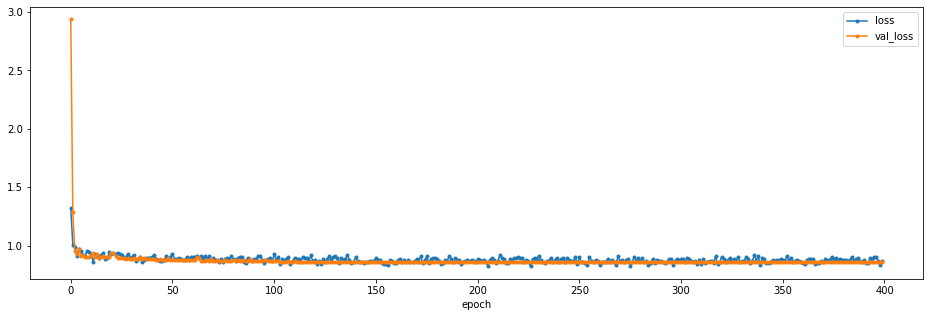

In [64]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

## Export Model to be Used with CSBDeep Fiji Plugins and KNIME Workflows
See https://github.com/CSBDeep/CSBDeep_website/wiki/Your-Model-in-Fiji for details.

In [18]:
model.export_TF()



Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /tmp/tmp2i9zkw0x/model/saved_model.pb

Model exported in TensorFlow's SavedModel format:
/home/ninatubau/n2v/examples/3D/models/n2v_3D_edwin/TF_SavedModel.zip
